In [616]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob as glob
#import scipy.misc


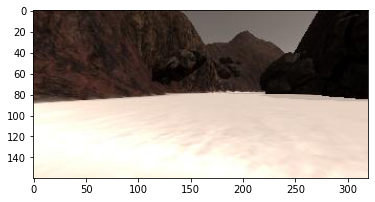

In [617]:
#1)first we will get a random image from the test images recorded to perform the pipeline on
path = "../test_dataset/IMG/*"
img_list = glob.glob(path)
#glob returns a list of files in this directory (images)
idx = np.random.randint(0,len(img_list)-1) # return a random integer
img = mpimg.imread(img_list[idx]) #read an image 
#mpimg is matplotlib, reads rgb directly
plt.imshow(img)

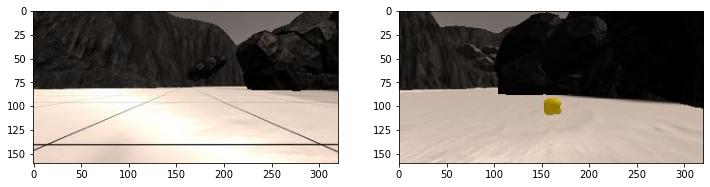

In [618]:
#2)get also a grid img and a rock img for testing

#Read and view Images of the grid and the rock
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"

grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

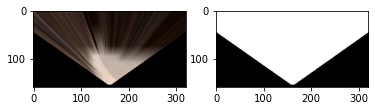

In [619]:
#3)we will get the bird eye view of each test image using perspective transform
def perspect_transform(img,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    #this mask will help in obstacle thresholding later
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]),M,(img.shape[1], img.shape[0]))
    warped = cv2.warpPerspective(img,M,(img.shape[1], img.shape[0]))
    return warped,mask

#testing with different dst_size and bottom_offset
dst_size = 5
bottom_offset = 7
#choose random image
index = np.random.randint(0,len(img_list)-1)
image = mpimg.imread(img_list[index])
#hardcoding the source for now
source = np.float32([[20,137],
                     [300,137],
                     [200,95],
                     [120,95]])

destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                     [image.shape[1]/2 + dst_size,image.shape[0] - bottom_offset],
                     [image.shape[1]/2 + dst_size,image.shape[0] -2*dst_size- bottom_offset],
                     [image.shape[1]/2 - dst_size,image.shape[0] -2*dst_size- bottom_offset]])


warped,mask= perspect_transform(image,source,destination)     
plt.subplot(121)
plt.imshow(warped)    
plt.subplot(122)    
plt.imshow(mask,cmap="gray")   
    

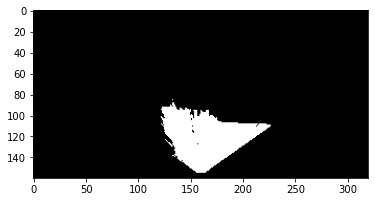

In [620]:
#4)we will apply color thresholding on the warped(bird eye view)image and the result will represent the navigable terrain for the rover
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,2])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshold = color_thresh(warped)
plt.imshow(threshold,cmap="gray")


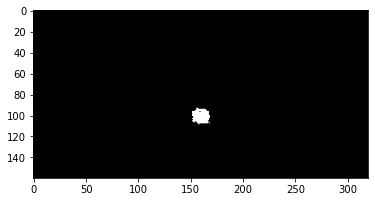

In [621]:
#5)a thresholding function for the rocks was also made
def rock_thresh(img, yellow_thresh=(100, 100, 20)):
    x = np.zeros_like(img[:,:,0])

    rock = (img[:,:,0] > yellow_thresh[0]) \
                & (img[:,:,1] > yellow_thresh[1]) \
                & (img[:,:,2] < yellow_thresh[2])

    x[rock] = 1
    return x

rock = rock_thresh(rock_img)
plt.imshow(rock,cmap="gray")


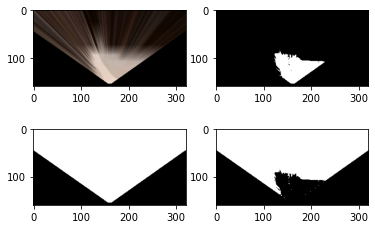

In [622]:
#6)to get the obstacle threshold we will invert the binary image of navigable terrain andmultiply it by the mask we created before
#to get a binary image of non-navigable parts(obstacles)
obs_thresh = np.absolute(np.float32(threshold)-1)*mask
plt.subplot(221)
plt.imshow(warped)
plt.subplot(222)
plt.imshow(threshold,cmap="gray")
plt.subplot(223)
plt.imshow(mask,cmap="gray")   
plt.subplot(224)
plt.imshow(obs_thresh,cmap="gray")

In [623]:
#7)we now have three binary images of the navigable terrain, obstacles and rocks
#we need to convert the coordinates of the resulted images to match the current coordinates of the rover
#the we will map the resulted coordinates to he world map coordinates to display the navigable terrain, obstacles and rocks on the world map
#we will do so by rotating the rover coordinates we got by the yaw angle of the rover to be parallel to the world map coordinates
#then by scaling and translation, the coordinates will be mapped to the world map coordinates and the results of our pipeline will be shown on it

#8) we need to update the yaw angle of the rover according to the resulted navigable terrain
#we will convert the coordinates of the navigable terrain binary image to polar coordinates to get the angle of each pixel
#by averaging the angles of all pixels we will get an angle in a certain direction according to the navigable terrain
#we will update the yaw angle of the rover by this angle

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    print(ypos)
    print (xpos)
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world




[ 95  95  95 ... 159 159 159]
[126 127 128 ... 169 170 171]


/tmp/ipykernel_70641/1225471086.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_70641/1225471086.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)


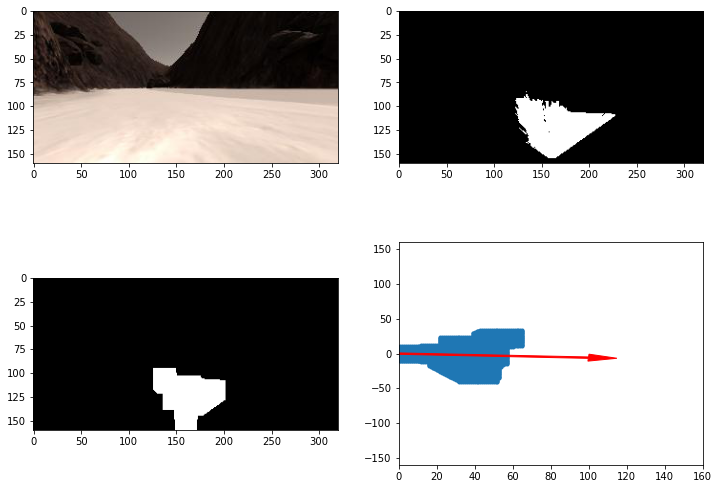

In [624]:

#testing

#calculate pixel values in rover-centric coords and distance/angle to all pixels

kernelb = np.ones((21,21),np.uint8)
kernels = np.ones((21,21),np.uint8)

thresholde = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernelb)
thresholde = cv2.morphologyEx(thresholde, cv2.MORPH_CLOSE, kernels)
#thresholde = cv2.erode(threshold,kernel,iterations = 1)

xpix,ypix = rover_coords(thresholde)
dist,angles = to_polar_coords(xpix,ypix)
mean_dir = np.mean(angles)


fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(threshold,cmap="gray")
plt.subplot(223)
plt.imshow(thresholde,cmap="gray")
plt.subplot(224)
plt.plot(xpix,ypix,'.')
plt.ylim(-160,160)
plt.xlim(0,160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0,0,x_arrow,y_arrow,color='red',zorder=2,head_width=10,width=2)



In [577]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [578]:
def mapping1(values_x,a,b,c): 
    return a*values_x**2+b*values_x+c 


args, covar = curve_fit(mapping1,xpix,ypix)

a,b,c = args[0], args[1], args[2] 

x0 = 5
x1 = 10

y0 = mapping1(x0,a,b,c)
y1 = mapping1(x1,a,b,c)


print (x0,y0)
print (x1,y1)


a = np.arctan((y1-y0)/(x1-x0))



print (a*180/(2*np.pi))

5 10.670453591280662
10 6.314530083269506
-20.530940845721435


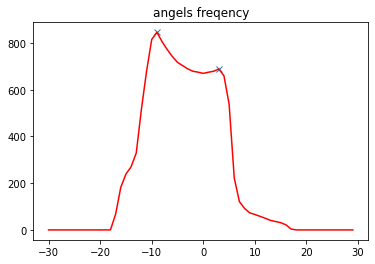

[-27   9]


In [160]:
s = 3
size = int (180 / s)
shift = int (size /2)

simplified_prefix = np.zeros(size)
down = (np.array((range(size)))- shift)



for x in angles:
    f= x*360 / (2*np.pi)
    simplified_prefix[round (f/s)+shift]+=1



simplified_peaks, _ = find_peaks(simplified_prefix, distance=s*1,height=np.max(simplified_prefix)/3, threshold = 1)


plt.title("angels freqency")
plt.plot(simplified_peaks-shift, simplified_prefix[simplified_peaks], "x")
plt.plot(down, simplified_prefix, color="red")
plt.show()


print((simplified_peaks-shift)*s)



In [935]:
def cost(peak, prefix):
    ans=prefix[peak]
    return ans




ans = simplified_peaks[0]

for p in simplified_peaks:
    if (   cost(p,simplified_prefix) > cost(ans,simplified_prefix)    ):
        ans = p

print (simplified_peaks)

print (ans)

[11 27]
27


In [903]:
def cost(peak, prefix, xo, yo, yaw, vis):
    
    c=0
    for r in range (10):
        x= r *np.sin(yaw)
        x = round(x)
        y = r * np.cos(yaw)
        y = round (y)

        
        for t in range (-1,2):
            for r in range (-1,2):
                jj = t+yo+y
                ii = r+xo+x
                if (jj) > -1  and (ii) > -1 and (jj) < 20  and (ii) <20:
                    c+= vis[jj][ii]


    ans = prefix[peak] - 20*c
    return ans


In [848]:
simplified_peaks

array([ 9, 24])

In [629]:
vis = np.zeros((20,20))



xo = 2
yo = 2

a = 10* np.pi / 180

for r in range (10):
    x= r *np.sin(a)
    x = round(x)
    y = r * np.cos(a)
    y = round (y)


    for t in range (-1,2):
        for r in range (-1,2):
            jj = t+yo+y
            ii = r+xo+x
            if (jj) > -1  and (ii) > -1 and (jj) < 20  and (ii) <20:
                vis[jj][ii]=1

vis[yo][xo] = 2
            
print (vis)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [846]:
for t in range (-1,2):
        for r in range (-1,2):
            if (t+yo+y) > -1 and (t+yo+y) < 20  and (r+xo+x) > -1 and (r+xo+x)  < 20:
                vis[t+yo+y][t+xo+x]=1

In [847]:
x = range(-1, 2)

for n in x:
	for r in x:
 		print(n,r)

-1 -1
-1 0
-1 1
0 -1
0 0
0 1
1 -1
1 0
1 1
